In [20]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf




In [2]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')

In [8]:
def import_data(which_path=2):
    if which_path==1:
        images_directory = path/'train_images'
    else: 
        images_directory = path/'train_images2'
    cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='training', validation_split=.2, seed=10)
    cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(97,97), subset='validation', validation_split=.2, seed=10)
    return (cb_training, cb_validation)


def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True,save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

# CNN lets overtrain 

In [27]:
cnn = None
keras.backend.clear_session()


filename = 'cnn-overtrain.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)



# cnn = Sequential()
# cnn.add(InputLayer(input_shape=(97,97, 3)))
# cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
# cnn.add(MaxPooling2D())
# cnn.add(Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'))
# cnn.add(GlobalAveragePooling2D())

# cnn.add(layers.Dense(100, activation='relu'))
# cnn.add(layers.Dense(100, activation='relu'))
# cnn.add(layers.Dense(100, activation='relu'))


# cnn.add(layers.Dense(1, activation='sigmoid'))
# cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

cnn = load_model(filename)

# history = cnn.fit(cb_training, epochs=20,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])
history2 = cnn.fit(cb_training, epochs=20,validation_data=cb_validation, class_weight = class_weight)


Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/20
750/750 [==============================] - 83s 107ms/step - loss: 0.1561 - tp: 5417.0000 - fp: 1650.0000 - tn: 16722.0000 - fn: 211.0000 - accuracy: 0.9225 - precision: 0.7665 - recall: 0.9625 - auc: 0.9823 - prc: 0.9393 - val_loss: 0.2287 - val_tp: 1284.0000 - val_fp: 465.0000 - val_tn: 4136.0000 - val_fn: 115.0000 - val_accuracy: 0.9033 - val_precision: 0.7341 - val_recall: 0.9178 - val_auc: 0.9666 - val_prc: 0.8982
Epoch 2/20
750/750 [==============================] - 81s 108ms/step - loss: 0.1595 - tp: 5423.0000 - fp: 1633.0000 - tn: 16739.0000 - fn: 205.0000 - accuracy: 0.9234 - precision: 0.7686 - recall: 0.9636 - auc: 0.9818 - prc: 0.9343 - val_loss: 0.2434 - val_tp: 1339.0000 - val_fp: 541.0000 - val_tn: 4060.0000 - val_fn: 60.0000 - val_accuracy: 0.8998 - val_precision: 0.7122 - val_recall: 0.9571 - val_auc: 0.9704 - va

Epoch 20/20
750/750 [==============================] - 80s 106ms/step - loss: 0.0985 - tp: 5533.0000 - fp: 944.0000 - tn: 17428.0000 - fn: 95.0000 - accuracy: 0.9567 - precision: 0.8543 - recall: 0.9831 - auc: 0.9923 - prc: 0.9711 - val_loss: 0.2505 - val_tp: 1255.0000 - val_fp: 406.0000 - val_tn: 4195.0000 - val_fn: 144.0000 - val_accuracy: 0.9083 - val_precision: 0.7556 - val_recall: 0.8971 - val_auc: 0.9639 - val_prc: 0.8915


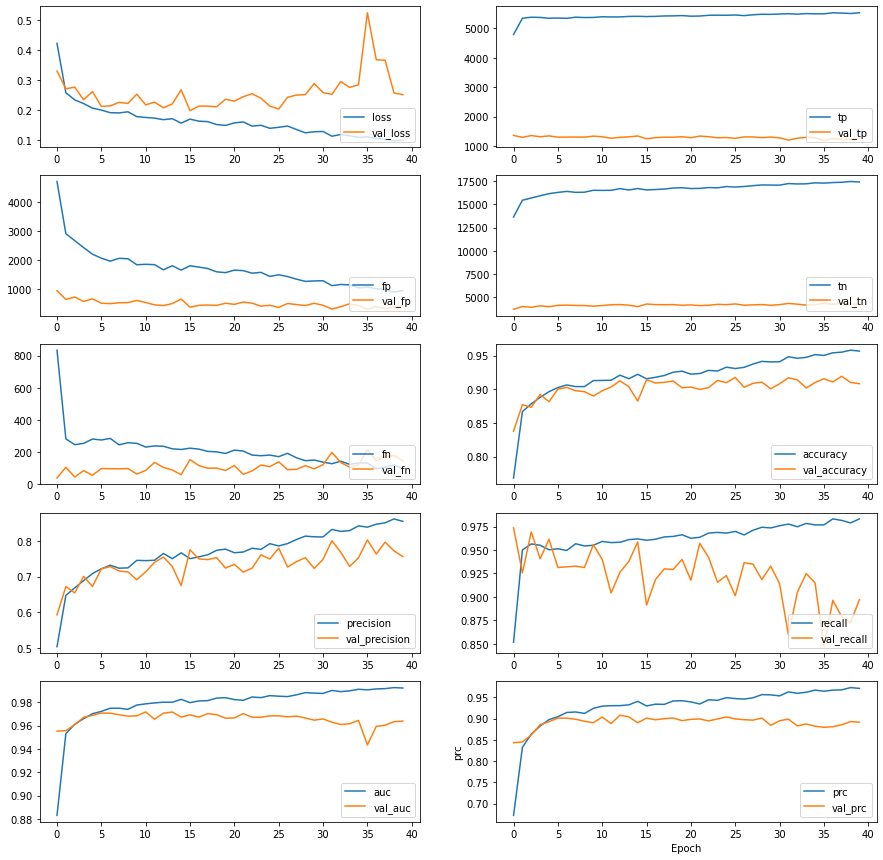

In [29]:
hist = history.history
hist2 = history2.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key]+hist2[key], label=key)
        ax.plot(hist[val_key]+hist2[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

# Analysis 

Val Recall is dropping like a rock - thats bad.  
Val loss is slowly growing.  
Val accuracy is leveled off - we're not seeing a drop, but with the other values getting worse, and our misbalanced sets, Im ok with that.  
Val auc is dropping off. 

## Are we overfitting? 
Yes. 

## What shall we do next? 
That recall is concerning. Lets inspect the confusion matrix 

In [186]:
cnn=None
keras.backend.clear_session()

cnn = load_model(filename) #Get the best version


predictions = [i[0] for i in cnn.predict_classes(cb_validation)]

In [214]:
predictions = cnn.predict_classes(cb_validation, verbose=2)
print(predictions)
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

188/188 - 3s
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
{0: 4423, 1: 1577}


In [188]:
cnn.evaluate(cb_validation,verbose=2)

188/188 - 5s - loss: 0.1867 - tp: 1250.0000 - fp: 327.0000 - tn: 4274.0000 - fn: 149.0000 - accuracy: 0.9207 - precision: 0.7926 - recall: 0.8935 - auc: 0.9712 - prc: 0.9094


[0.1867004781961441,
 1250.0,
 327.0,
 4274.0,
 149.0,
 0.9206666946411133,
 0.7926442623138428,
 0.8934953808784485,
 0.971164882183075,
 0.9094194173812866]

In [215]:
labels = np.concatenate([y for x, y in cb_validation], axis=0)
print(lables)
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


NameError: name 'lables' is not defined

188/188 - 3s


{0: 4423, 1: 1577}

In [187]:
tf.math.confusion_matrix(predictions, labels)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3392, 1031],
       [1209,  368]], dtype=int32)>

In [156]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 97, 5)         140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 10)        460       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 30)        5

In [171]:
cnn.evaluate(cb_validation,verbose=2)


188/188 - 4s - loss: 0.1867 - tp: 1250.0000 - fp: 327.0000 - tn: 4274.0000 - fn: 149.0000 - accuracy: 0.9207 - precision: 0.7926 - recall: 0.8935 - auc: 0.9712 - prc: 0.9094


[0.18670053780078888,
 1250.0,
 327.0,
 4274.0,
 149.0,
 0.9206666946411133,
 0.7926442623138428,
 0.8934953808784485,
 0.971164882183075,
 0.9094194173812866]